In [2]:
import sys
import os
import copy
import traceback

########################
# Find qslam modules
########################
sys.path.append('../qslam/')

from qslamdesignparams import GLOBALDICT
from riskanalysis import CreateQslamExpt as riskqslam
from riskanalysis import CreateNaiveExpt as risknaive
from riskanalysis import EngineeredTruth
from visualiserisk import *

sys.path.append('../qslam')
sys.path.append('../paduaq')
from pdinter_MM import pd_interpolant, calc_padua_cgl
from true_functions import true_function, generate_data_qubits_coords

sys.path.append('./')

In [3]:
#####################
# Set Simulation Params
########################
idx_functype= 3

if idx_functype ==0:
    true_function_type = 'cheb2fun'
    from tuningresults_nonpoly import SIMULATIONSDICT
    
if idx_functype ==1:
    true_function_type = 'lin'
    from tuningresults_linear import SIMULATIONSDICT

if idx_functype ==2:
    true_function_type = 'franke'
    from tuningresults_franke import SIMULATIONSDICT

if idx_functype ==3:
    true_function_type = 'franke_2'
    from tuningresults_franke_2 import SIMULATIONSDICT

path = './data/'


data_qubit_num = 25
data_qubit_flag ='uniform'
data_qubits = generate_data_qubits_coords(data_qubit_num,
                                          flag=data_qubit_flag)

TRUTHKWARGS = {}
TRUTHKWARGS["truthtype"] = "UseFunction"
TRUTHKWARGS["true_function"] = true_function
TRUTHKWARGS["true_function_type"] = true_function_type

GLOBALDICT["MODELDESIGN"]["MSMTS_PER_NODE"] = 1
GLOBALDICT["MODELDESIGN"]["MULTIPLER_R_MAX"] = 4.
repts = 50
particleconfigs = [ [3,2], [9,6], [15,10], [21,14], [30, 20]]

lambda_paris_2 = np.load('lambda_pairs_2.npz')
random_variances = np.load('random_variances.npz')


# Regimes

In [4]:
prefix_list = [1, 2, 3, 4, 5, 10]
opt_method = "Uniform" # SIMULATIONSDICT[padua_order]["Opt_Beta_Expn"] 
filenameslist=[]
for padua_order in prefix_list: 
    
    prefix = true_function_type+'_padua_ord_'+str(padua_order)+'_'
    
    idx_1 = SIMULATIONSDICT[padua_order][opt_method]["optimal"]["idx_1"]
    idx_2 = SIMULATIONSDICT[padua_order][opt_method]["optimal"]["idx_2"]
    idx_3 = SIMULATIONSDICT[padua_order][opt_method]["optimal"]["idx_3"]
    
    fname_likelihood = 'optidx_'+str(idx_1)+'_'+str(idx_2)+'_'+str(idx_3)
    regime_ID = prefix + fname_likelihood
    datafile = path+'RISK_' + regime_ID +'.npz'
    filenameslist.append(datafile) 
    


Multiples = [1, 3, 5, 7, 9, 10, 15, 20, 50]
filenameslist

['./data/RISK_franke_2_padua_ord_1_optidx_29_18_4.npz',
 './data/RISK_franke_2_padua_ord_2_optidx_13_13_0.npz',
 './data/RISK_franke_2_padua_ord_3_optidx_6_7_0.npz',
 './data/RISK_franke_2_padua_ord_4_optidx_24_8_2.npz',
 './data/RISK_franke_2_padua_ord_5_optidx_29_18_1.npz',
 './data/RISK_franke_2_padua_ord_10_optidx_29_18_0.npz']

# Single Run Maps

(1, 28)


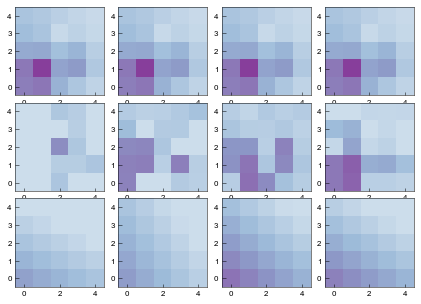

(2, 31)


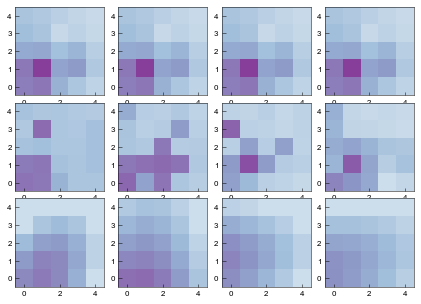

(3, 35)


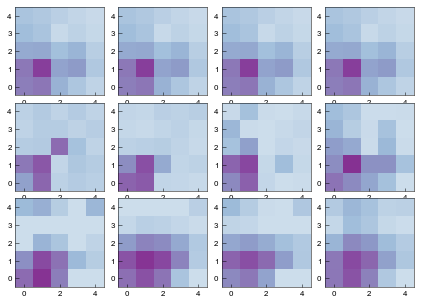

(4, 40)


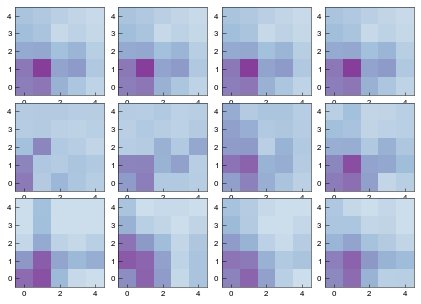

(5, 46)


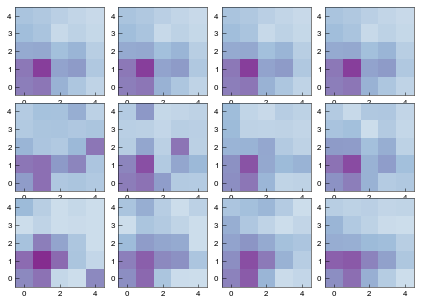

(10, 91)


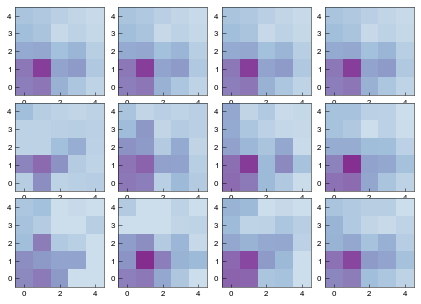

In [5]:
qax = qPlotter()
PICK = [24, 30, 20] # np.random.randint(low=0, high=50)

gslayout = gs(3, 4, top = 0.95, bottom =0.05, left = 0.05, right = 0.95, wspace = 0.05, hspace = 0.08)

pick_msmt_regimes = [2, 4, 7 , 8]

for idx_truth in range(len(prefix_list)):
    
    padua_order = prefix_list[idx_truth]
    sensing_qubits = calc_padua_cgl(padua_order)[0]
    

    GLOBALDICT["DATA_QUBITS"] = np.arange(len(sensing_qubits),  len(sensing_qubits) + data_qubit_num, dtype='int')
    GLOBALDICT["INTERPOLATE_FLAG"] = padua_order
    TRUTHKWARGS["all_qubit_locations"] = sensing_qubits 
    if GLOBALDICT["DATA_QUBITS"] is not None:
        TRUTHKWARGS["all_qubit_locations"] = sensing_qubits + data_qubits
    num_of_nodes = len(TRUTHKWARGS["all_qubit_locations"])
    true_map_ =  EngineeredTruth(num_of_nodes, TRUTHKWARGS).get_map()

    GLOBALDICT["GRIDDICT"] = {}
    for idx_posy in range(1, num_of_nodes + 1):
        point = TRUTHKWARGS["all_qubit_locations"][idx_posy-1]
        if idx_posy < 10 :
            GLOBALDICT["GRIDDICT"]["QUBIT_0" + str(idx_posy)] = (point[0], point[1])
        if idx_posy >= 10 :
            GLOBALDICT["GRIDDICT"]["QUBIT_" + str(idx_posy)] =  (point[0], point[1])

    
    print (padua_order, num_of_nodes)
    fig = plt.figure(figsize=(cm2inch(16),cm2inch(11)))
    
    sensing_qubt_num = len(TRUTHKWARGS["all_qubit_locations"]) - data_qubit_num
    x_points=[]
    y_points=[]
    for idx_point in range(num_of_nodes):
        x_points.append((TRUTHKWARGS["all_qubit_locations"][idx_point][0] + 1.0) *4.0 /2.0)
        y_points.append((TRUTHKWARGS["all_qubit_locations"][idx_point][1]+ 1.0)*4.0 /2.0)
    
    LINFLAG = False

    for idx_msmt_regime in range(len(pick_msmt_regimes)):
        
        idx_msmt_var = Multiples[pick_msmt_regimes[idx_msmt_regime]]
        
        prefix = true_function_type+'_padua_ord_'+str(padua_order)+'_'
    
        idx_1 = SIMULATIONSDICT[padua_order][opt_method]["optimal"]["idx_1"]
        idx_2 = SIMULATIONSDICT[padua_order][opt_method]["optimal"]["idx_2"]
        idx_3 = SIMULATIONSDICT[padua_order][opt_method]["optimal"]["idx_3"]
        
        fname_likelihood = 'optidx_'+str(idx_1)+'_'+str(idx_2)+'_'+str(idx_3)
        unique_ID = prefix + fname_likelihood + '_m_' + str(idx_msmt_var)

        PATHDICT["fle"] = unique_ID
        qslamdata = np.load(path_to_file(PATHDICT, flag='q'))
        naivedata = np.load(path_to_file(PATHDICT, flag='n'))
                
        dataobjs = [qslamdata]*2 + [naivedata]
        dataviews = ['macro_true_fstate', 'macro_predictions', 'macro_predictions']
        
        for item in range(3):
            ax = fig.add_subplot(gslayout[item, idx_msmt_regime])
            ax.imshow(dataobjs[item][dataviews[item]][:, 49, sensing_qubt_num:].reshape(5,5), **HEATMAP)
            # ax.imshow(plot2.reshape(5,5), **HEATMAP)
           
    # plt.colorbar(cax, ticks=[0.0, np.pi], format='%0.2f', orientation='horizontal')
    plt.savefig('./data_figs/'+true_function_type+'_'+'SingleRunMaps'+str(prefix_list[idx_truth])+'_maps.svg', format='svg', dpi=800)
    plt.show()
    